In [14]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
from src.clr import LRFinder, OneCycleLR
import matplotlib.ticker as ticker

## Fix std predictions

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(5)
limit_mem()

In [16]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [17]:
args = load_args('../nn_configs/B/100-resnet_d3_param.yml')

In [20]:
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [21]:
dg_test = load_data(**args, only_test=True)

In [23]:
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'crps_loss': tf.keras.losses.mse})

In [24]:
preds = create_predictions(model, dg_test, parametric=True)

In [26]:
preds.to_netcdf('/home/rasp/data/myWeatherBench/predictions/100-resnet_d3_param.nc')

## Check out why they are bad

In [6]:
import matplotlib.pyplot as plt
import xarray as xr
from src.score import *

In [7]:
valdir = '/data/stephan/WeatherBench/5.625deg/'
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [27]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions/100-resnet_d3_param.nc')

In [28]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8722)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z-std    (time, lat, lon) float64 ...
    t-mean   (time, lat, lon) float64 ...
    z-mean   (time, lat, lon) float64 ...
    t-std    (time, lat, lon) float64 ...

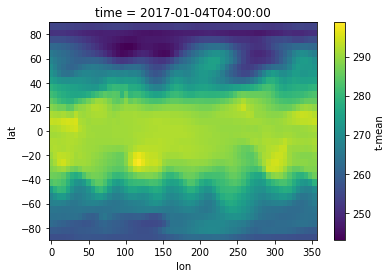

In [31]:
t = preds.time[0]
preds['t-mean'].sel(time=t).plot()

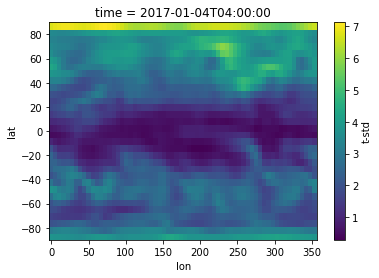

In [58]:
np.abs(preds['t-std'].sel(time=t)).plot()

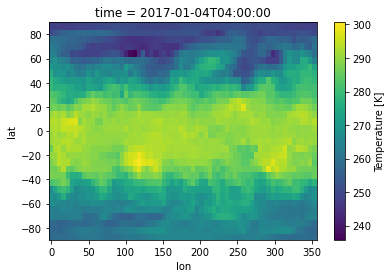

In [33]:
valid['t'].sel(time=t).plot()

In [51]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat))
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat).mean(mean_dims)
    return crps

In [53]:
compute_weighted_crps_gaussian(
    valid, 
    preds[['z-mean','t-mean']].rename({'z-mean':'z','t-mean':'t'}),
    np.abs(preds[['z-std','t-std']].rename({'z-std':'z','t-std':'t'})),
).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 184.0
    t        float64 1.109

In [54]:
crps = compute_weighted_crps_gaussian(
    valid, 
    preds[['z-mean','t-mean']].rename({'z-mean':'z','t-mean':'t'}),
    np.abs(preds[['z-std','t-std']].rename({'z-std':'z','t-std':'t'})),
    mean_dims=['time']
).load()

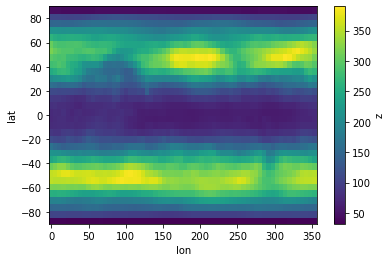

In [56]:
crps.z.plot()

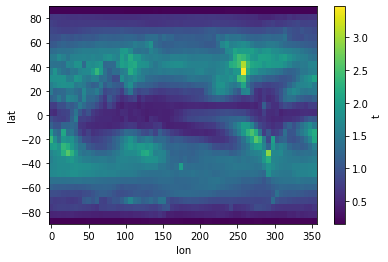

In [57]:
crps.t.plot()

In [60]:
compute_weighted_rmse(valid, preds[['z-mean','t-mean']].rename({'z-mean':'z','t-mean':'t'})).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 414.4
    t_rmse   float64 2.236

In [62]:
rmse = compute_weighted_rmse(
    valid, 
    preds[['z-mean','t-mean']].rename({'z-mean':'z','t-mean':'t'}),
    mean_dims='time'
).load()

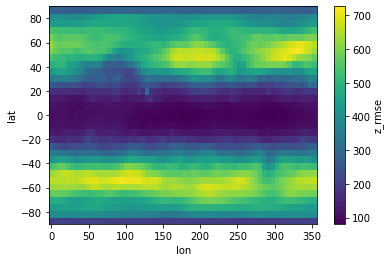

In [65]:
rmse.z_rmse.plot()

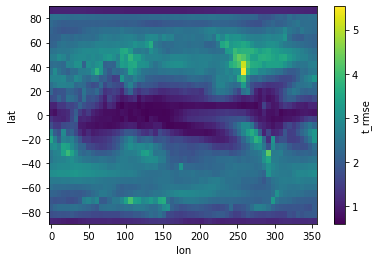

In [66]:
rmse.t_rmse.plot()